In [1]:
import numpy as np
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
from functools import partial
import math
import torch
from torch.optim.optimizer import  required
import itertools as it

from fastai.torch_core import *
import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from functools import partial
#from ...torch_core import Module
from fastai.torch_core import Module
import torch.nn.functional as F 
from torch.nn.utils import spectral_norm

In [2]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x):  
        #save 1 second per epoch with no x= x*() and then return x...just inline it.
        return x *( torch.tanh(F.softplus(x))) 
        


    

#Unmodified from https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)



# Adapted from SelfAttention layer at https://github.com/fastai/fastai/blob/5c51f9eabf76853a89a9bc5741804d2ed4407e49/fastai/layers.py
# Inspired by https://arxiv.org/pdf/1805.08318.pdf
class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):#, n_out:int):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
        
        
        if self.sym:
            # symmetry hack by https://github.com/mgrankin
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)
                
        size = x.size()  
        x = x.view(*size[:2],-1)   # (C,N)
        
        # changed the order of mutiplication to avoid O(N^2) complexity
        # (x*xT)*(W*x) instead of (x*(xT*(W*x)))
        
        convx = self.conv(x)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())   # (C,N) * (N,C) = (C,C)   => O(NC^2)
        
        o = torch.bmm(xxT, convx)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
          
        o = self.gamma * o + x
        
          
        return o.view(*size).contiguous()        
        


    
    
__all__ = ['MXResNet', 'mxresnet18', 'mxresnet34', 'mxresnet50', 'mxresnet101', 'mxresnet152']

# or: ELU+init (a=0.54; gain=1.55)
act_fn = Mish() #nn.ReLU(inplace=True)

class Flatten(Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False, sym=False):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.sa = SimpleSelfAttention(nf,ks=1,sym=sym) if sa else noop
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class MXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, sa = False, sym= False):
        stem = []
        sizes = [c_in,32,64,64]  #modified per Grankin
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2, sa = sa if i in[len(layers)-4] else False, sym=sym)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, sa=False, sym=False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [blocks -1] else False,sym)
              for i in range(blocks)])

def mxresnet(expansion, n_layers, name, pretrained=False, **kwargs):
    model = MXResNet(expansion, n_layers, **kwargs)
    if pretrained: 
        #model.load_state_dict(model_zoo.load_url(model_urls[name]))
        print("No pretrained yet for MXResNet")
    return model

Mish activation loaded...


In [3]:
def FlatCosAnnealScheduler(self:Learner, lr:float=4e-3, tot_epochs:int=1, start_pct:float=0.72,
                           curve='cosine'):
    n = len(self.dls.train)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":        curve_sched=SchedCos(lr, 0)
    elif curve=="linear":      curve_sched=SchedLin(lr, 0)
    elif curve=="exponential": curve_sched=SchedExp(lr, 0)
    else: raiseValueError(f"annealing type not supported {curve}")
    scheds = [SchedNo(lr, start_pct), curve_sched]
    scheds = {'lr': combine_scheds([start_pct, 1-start_pct], scheds)}
    return scheds

In [4]:
path = Path('../data/')
train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')
submission = pd.read_csv(path / 'sample_submission.csv')

def get_digits(row, has_label=True):
    
    if has_label: row = row.drop('label')
    return np.uint8(row.values.reshape(28,28))

def get_label(row):
    
    return row['label']

data_block_train = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_x = get_digits,
                       get_y = get_label,
                       splitter = RandomSplitter(seed = 123),
                       batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
                      )
dataloader_train = data_block_train.dataloaders(train)

In [5]:
opt_func = partial(ranger, wd=1e-2,  betas=(.95,.9), eps=1e-1, weight_decay=1e-2)
loss_func = LabelSmoothingCrossEntropy()
model = MXResNet(4, [3,4,6 ,3], c_out=10, sa=True)

In [6]:
learner = Learner(dataloader_train, model, opt_func=opt_func,
             metrics=[accuracy],
             loss_func = loss_func)#.to_fp16(dynamic=True)

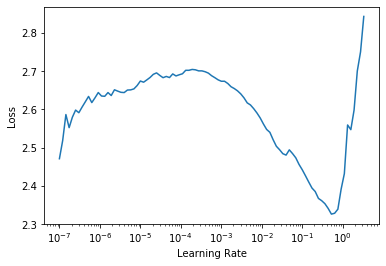

In [7]:
lr_min, lr_steep = learner.lr_find()

In [8]:
callbacks = ParamScheduler(FlatCosAnnealScheduler(learner, lr_steep, start_pct=.72, tot_epochs=20))
learner.fit(20, lr_steep, cbs=callbacks)

In [9]:
test_data = np.apply_along_axis(lambda x: Normalize.from_stats(*imagenet_stats)(x.reshape(28,28)).astype(np.uint8), 1, test)
for i in range(test.shape[0]):
    label, _, logits = learner.predict(test_data[i])
    submission.loc[i, 'Label'] = int(label)
submission.to_csv('submission_v5.csv', index=None)